In [ ]:
!pip install mplsoccer statsbombpy
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen
import statsbombpy
!pip install cmasher
!pip install highlight-text


In [ ]:
from urllib.request import urlopen
import warnings

import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from highlight_text import ax_text



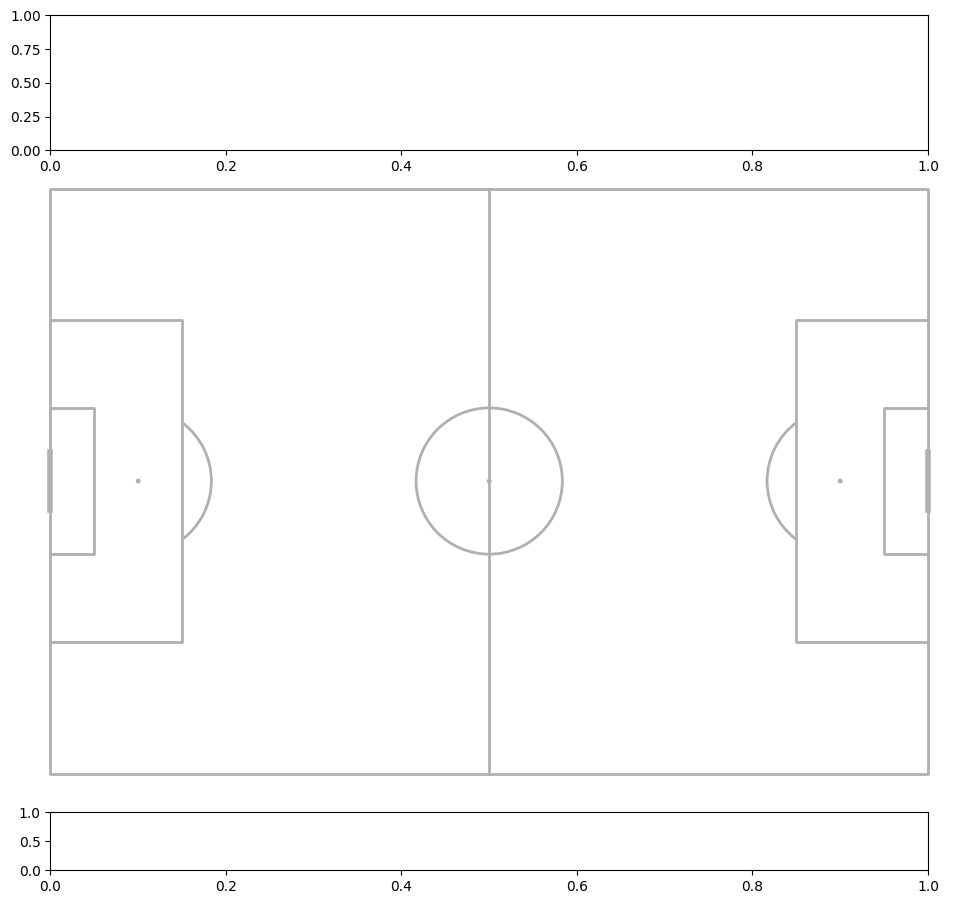

In [ ]:
pitch = Pitch()
fig, axs = pitch.grid()

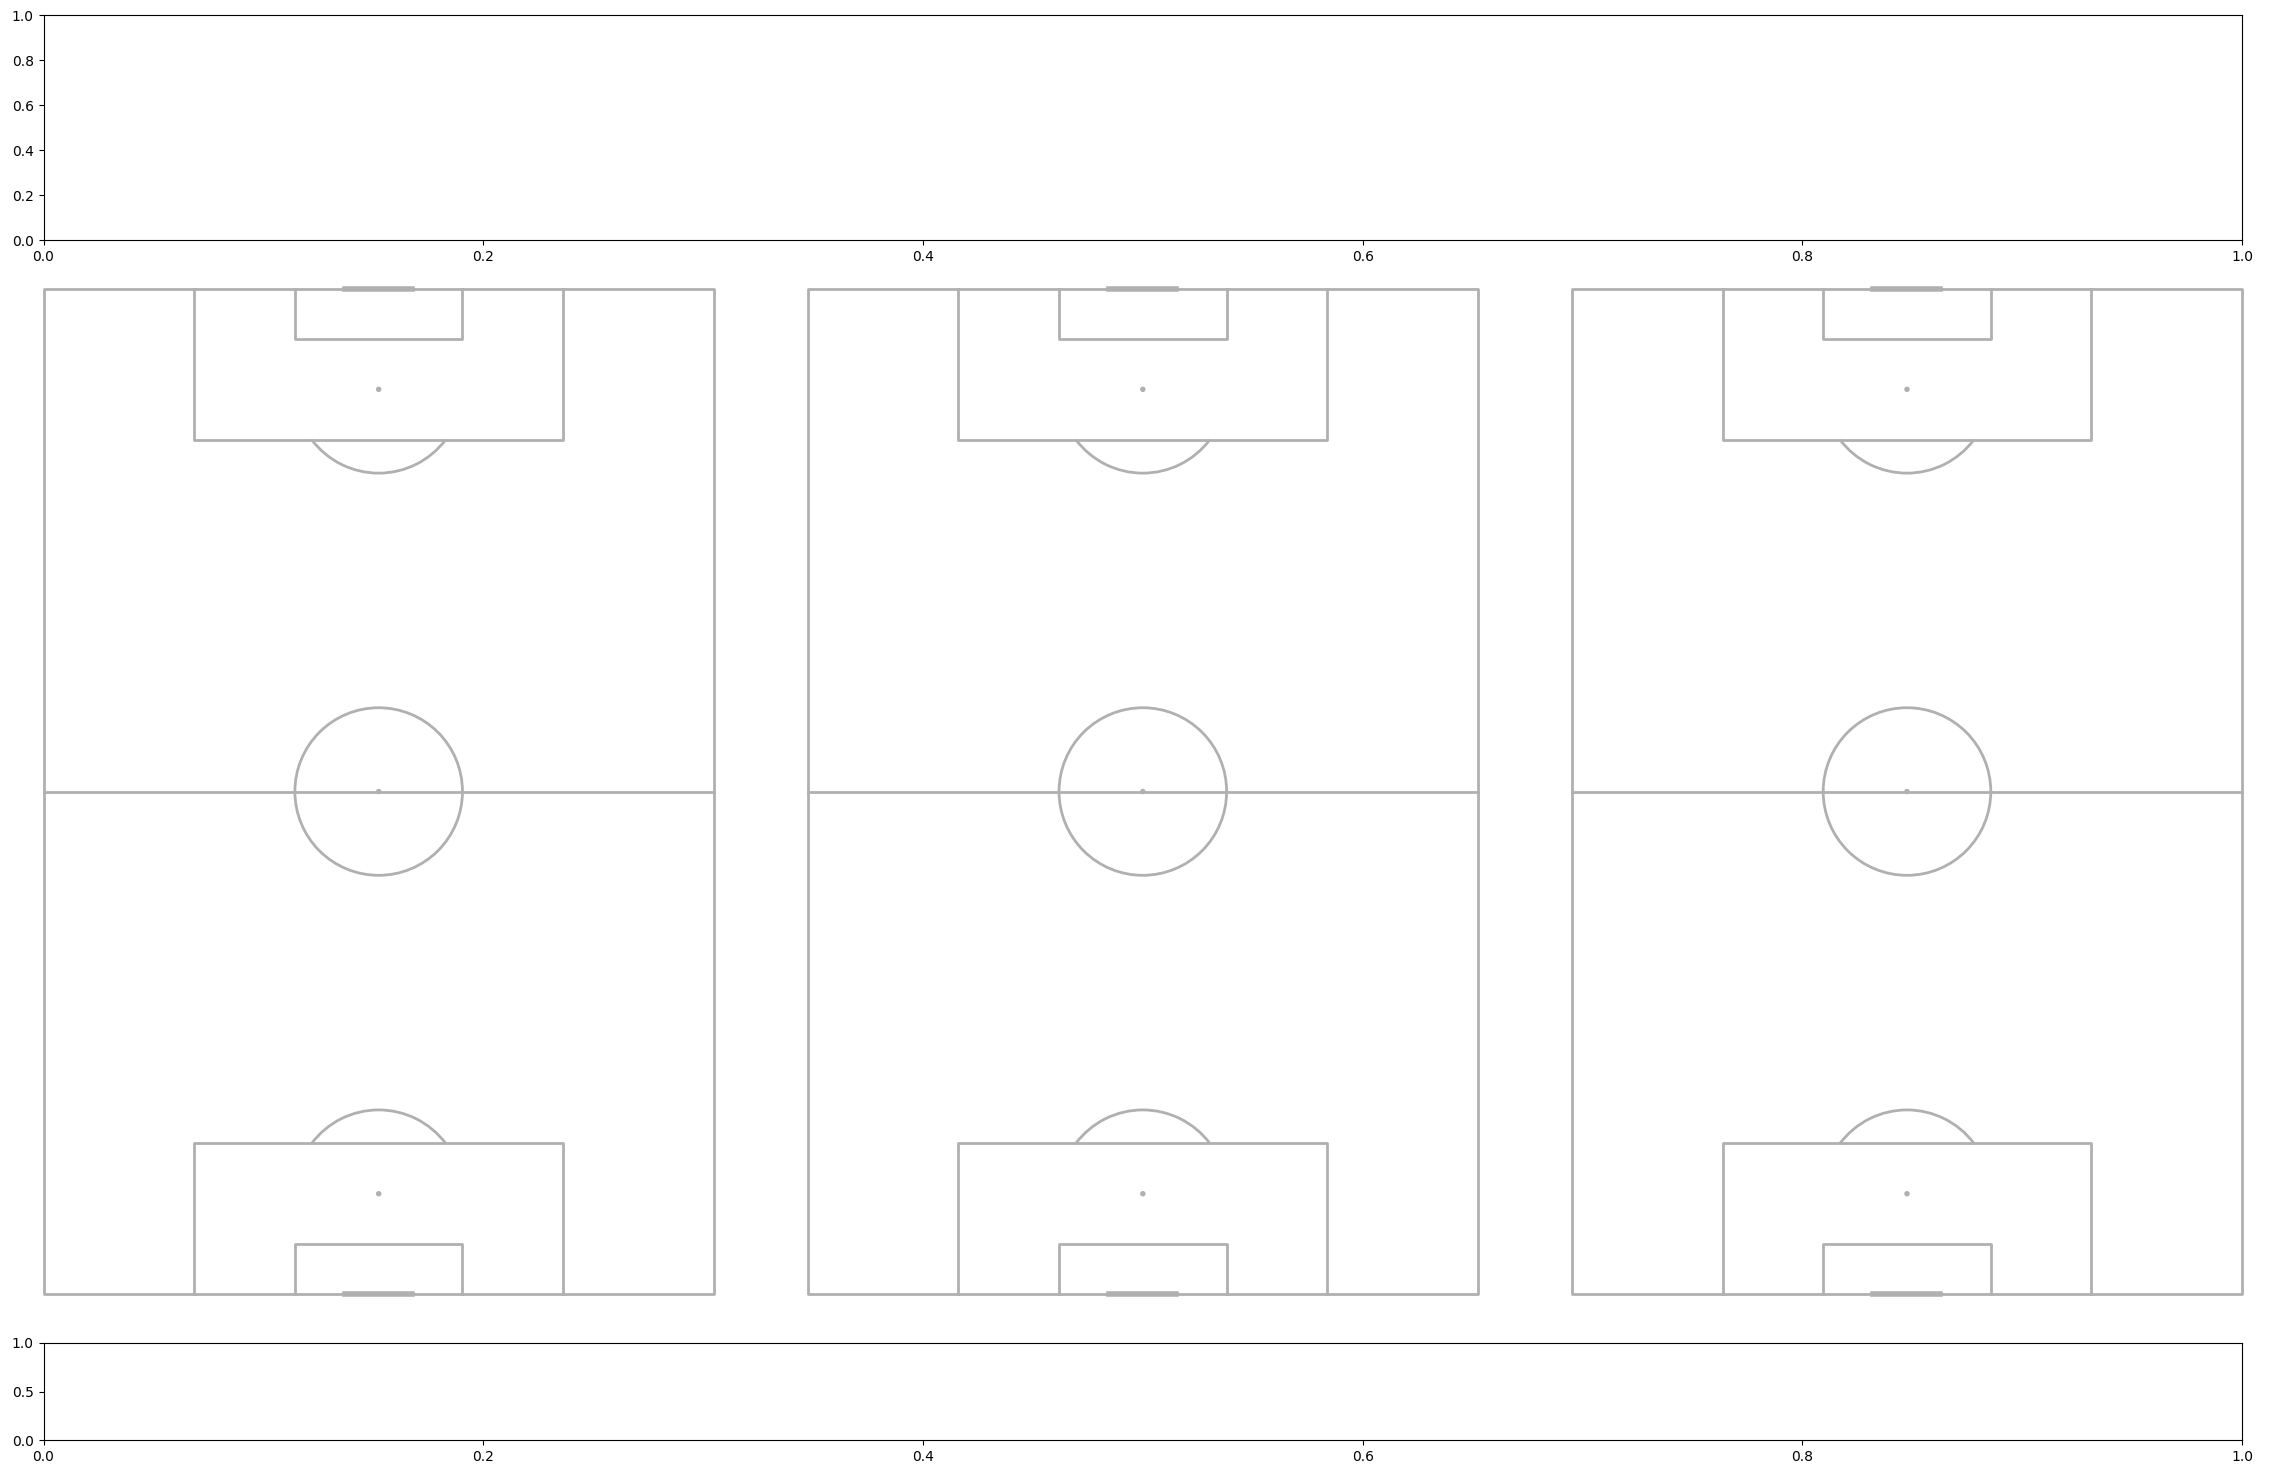

In [ ]:
pitch = VerticalPitch()
fig, axs = pitch.grid(figheight=15, ncols=3)

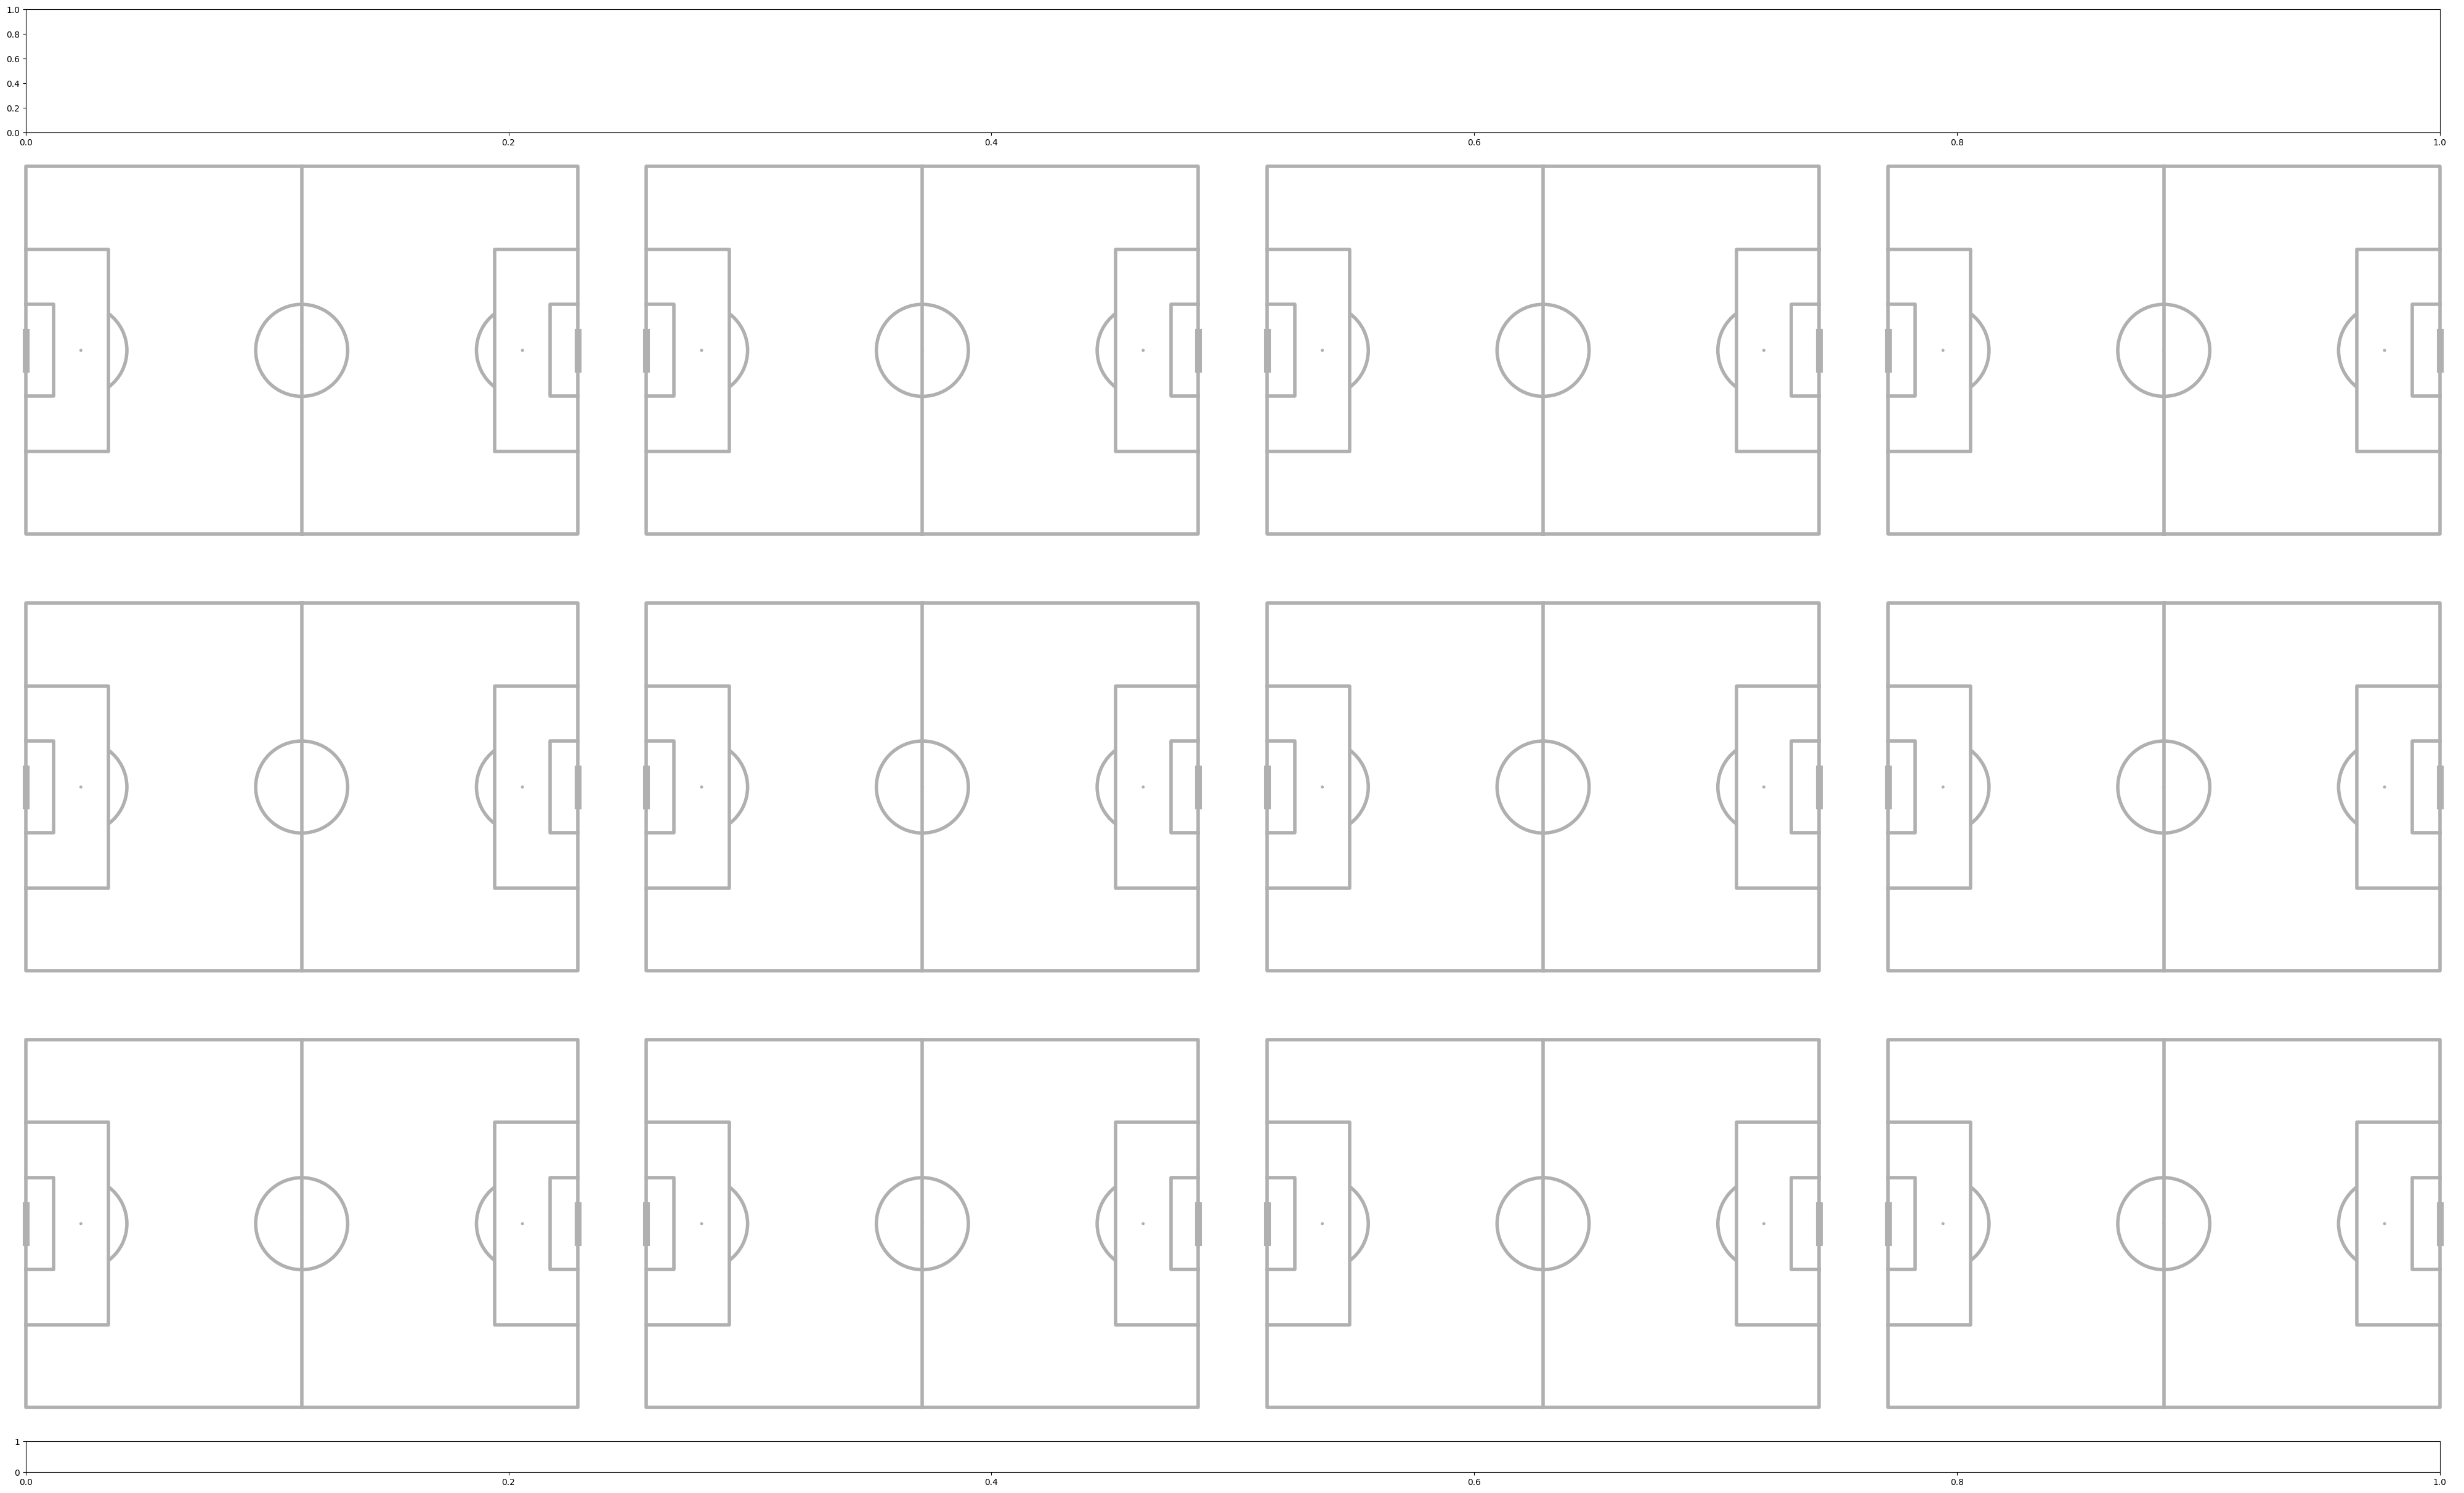

In [ ]:
pitch = Pitch(linewidth=4)
fig, axs = pitch.grid(nrows=3, ncols=4,  # number of rows/ columns
                      figheight=25,  # the figure height in inches
                      bottom=0.025,  # starts 2.5% in from the figure bottom
                      # grid takes up 83% of the figure height
                      # I calculated this so most of the figure is pitches
                      # 1 - (bottom + endnote_height + endnote_space +
                      # title_height + title_space) - 0.025 [space at top]
                      grid_height=0.83,
                      # reduced the amount of the figure height reserved
                      # for the ax_endnote and ax_title since it is in
                      # fractions of the figure height and the figure height
                      # has increased. e.g. now the title_height is
                      # 8% of the figheight (25).
                      grid_width=0.95,  # the grid takes up 95% of the figwidth
                      # 5% of the grid_height is the space between pitches.
                      space=0.05,
                      endnote_height=0.02, endnote_space=0.01,
                      title_height=0.08, title_space=0.01)

In [ ]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(3943043)
lineup = parser.lineup(3943043)

In [ ]:
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)
# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id
# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

In [ ]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)
print(lineup)

    player_id                      player_name   player_nickname  \
0        3468                  Jordan Pickford   Jordan Pickford   
1        3205                      Kyle Walker       Kyle Walker   
2        3244                      John Stones       John Stones   
3       34526                       Marc Guehi        Marc Guehi   
4        3382                        Luke Shaw         Luke Shaw   
5       99174                    Kobbie Mainoo     Kobbie Mainoo   
6        3943                      Declan Rice       Declan Rice   
7       22084                      Bukayo Saka       Bukayo Saka   
8        4354                       Phil Foden        Phil Foden   
9       30714                  Jude Bellingham   Jude Bellingham   
10      10955                       Harry Kane        Harry Kane   
11       4760                    Ollie Watkins     Ollie Watkins   
12      39461                      Cole Palmer       Cole Palmer   
13       3834                       Ivan Toney  

In [ ]:
# filter the lineup for Barcelona players
# if you want the other team set team = team2
team1, team2 = lineup.team_name.unique()  # Barcelona (team1), Deportivo Alavés (team2)
team = team2
lineup_team = lineup[lineup.team_name == team].copy()

# filter the events to exclude some set pieces
set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick Off', 'Goal Kick']
# for the team pass map
pass_receipts = events[(events.team_name == team) & (events.type_name == 'Ball Receipt')].copy()
# for the player pass maps
passes_excl_throw = events[(events.team_name == team) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players = len(lineup_team)
num_sub = num_players - 11

In [ ]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
                       'Scada-Regular.ttf')

# Load the Club/ Statsbomb logos
# these are the property of the respective clubs/ StatsBomb.
Spain_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/3/39/Spain_national_football_team_crest.svg/1200px-Spain_national_football_team_crest.svg.png')
England_LOGO_URL = ('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAKgAswMBIgACEQEDEQH/xAAbAAEAAwEBAQEAAAAAAAAAAAAABQYHBAMCAf/EAEsQAAEDAwICBQUNBQYEBwAAAAECAwQABREGIRIxBxNBUWEUInGBkhYXMjZCU1RzkaGxstMVIzRSdCRicoKiwTNDwvAlJmPR0uHx/8QAGgEAAwEBAQEAAAAAAAAAAAAAAAMEBQIBBv/EADMRAAEDAgMECQQCAwEAAAAAAAEAAgMRIQQSMRNBocEiM1FSYXGB4fAFMpGxFNEjQvEV/9oADAMBAAIRAxEAPwDcaUpQhK+C80CQXEAjsKhX3WRwNMQdTa21CzOcfaSy+taSwUgklZG/Ek06GJr6lxoAlveW0oK1Wsdez86j2hTr2fnUe0KovvT2L6Zcvba/Tp709i+mXL22v0672cHf4e65zyd3ir117PzqPaFOvZ+dR7Qqi+9PYvply9tr9OnvT2L6Zcvba/To2cHf4e6M8nd4q9dez86j2hTr2fnUe0KovvT2L6Zcvba/Tp709i+mXL22v06NnB3+HujPJ3eKvXXs/Oo9oU69n51HtCqL709i+mXL22v06e9PYvply9tr9OjZwd/h7ozyd3ir117PzqPaFOvZ+dR7Qqi+9PYvply9tr9OnvT2L6Zcvba/To2cHf4e6M8nd4q9dez86j2hTr2fnUe0KovvT2L6Zcvba/Tp709hzjyy4+21+nRs4O/w90Z5O7xV669n51HtCnXs/Oo9oVRfensX0y5e21+nT3p7F9MuXttfp0bODv8AD3Rnk7vFXrr2fnUe0K+0qSsZQoKHeDms+k9FdjajuuJl3ElCCoAqaxsPq66uh/HuUcwAMy18v8Ka8dEzIXsdWngvWvdmyuFFeKUpU6alKUoQlKUoQlZ9oj4/an+sV+c1oNZ9oj4/an+sV+c1TD1cnlzSn/c1WjV93Nj09LnIIDqE4bJSVALOwyB41S7ivWcO3rmu39hT0RsOvRktpGE8xlQThR3AIG3iavl/s0a+21yBMK0oUQoLbOFJI5EZqonTN8kut2SbqNj9nJjpCmWEBDy0JwBkYzjOBniPiN6zpmvJGXRbWBkhay9Kgkmoramg18bWvequVmuTF3tkefGJLbyM7jBB5EHxBBHqr1uE2PboT0yY4G2GUlS1Hu/3PhXzbLfGtcFmFCb6thoYSnJPM5Jz3kkmqN0v3VTMGJamynEkl17vCUEcP2n8tWYeMyPa0rKxD2NLnM03V4KVX0h2FEoNl5RZ8lD/AFwTnziRhvA34sHfu+3ErYtSQL1BalslTCXXS022+pIWpQ7gCfH7M1hEqFIiobcebIbcQhaHBukhSeIDPfjs57GviHKehSkS4bpakN54HEYyMgjb1E1qHARlvRN1CMS4G4W2a5utwhMQYNmcS3cJ8gNNqUkYCcEk5IwN8c+/bfFVyZdNQ2GTCudyvTU239eliS201w4JBKsDhGdgSCD6sVOydONaj09ZXV3Bfl0aO2tmc15wUopSSog8wSkHsO3ZvXKdIXe8Sj7q7siRBbcK2o0VPAFHlk7AjYntJ359/wA/KyTaW+fPVfS4SXDiEZ6b626V+w3rbyorq2tLiErQQpKgCkjtFQepNWWzTrjLU4ureeBUltpPEcd59J2Hf9tTiEpQhKEAJSkYAHYKzzWClWLXMHUM6IuRbQyGy4kZ6pXnD0fKBGeeTjcVdh2B76H/AKsWV2UVCg9QdIV8Xc3Rb1OW6OkAJYeYR1nIHKuIHffs7MV+6X1Ddbndm+o8qmXN7haelOODqozHECspQlICcgcyeYGKk785orUkxFxbvi4M0AZcShSeLHIkEcx3gj7hUnZfcrHfQ/M1K1cZCDlszZSQhtXelGwB8dz41eXRiOgjofL5X8qUBxdXNZdOrLrd1X2JZ7DKajOhlUmQ46gEBsEAcwcjnsN9uwVHWu73azakhR75d0z4NxQUMOJbCcLBABIwCnfbt51NXjTyLrco99stwQzcGk8KHRhxpYwobj/NjPca5rTpGa/PYuWq7h5dKjHMdprZpvBBB2SnJyO4DvztjBc2XafPnBfSRy4YQAOpSlDbpVPZrpa9RbdVWqd/BSPqlfhVO6H/AIqL/ql/lTVxnfwUj6pX4VTuh/4qL/ql/lTWizqHeY5rDd1g9eSvFKUqdNSlKUISlKUISs+0R8ftT/WK/Oa0Gs+0R8ftT/WK/Oaph6uTy5pT/uapvpEdXH027IYm+RyWlpUyvrlNlZzukYO5KQdjn/esma1JcHLtaptwlvPGA4jCs+eW+PKh4kjI8ds1tt7sVuvrSGrmwXUI3SA4pODtvsR3fj31VJ9i0rcX5FggsRYN2aHmFxpROMA8QKVDiODnBJPeKZhZYmAtc2/JezMkcAWusFbrTebbeGQ7bZjT4xkpSrzk+lJ3HrrKOlKKpjUPXKhBjrgSHRI4w+Bjfh+RjO47SSe+uHUGj7rYXlPIafejsjiEtCAnGASSAlSikAfKOO2vKQ3crtZ+rfamvz7a75yXErW51DqeIEg74SUZ7sLFVQQMjftGOqFLJI5zcrhQr7gQJYtqCHPKUtOtS2ITAS+X855oCgpIByFeb8o88VwOOXG9TWILvAHy4oJSW0tDrFHKirAG5I3z91fcidF8mWqKt1LrjCI6W+DAZQMcfnZ34iDyxkLVnGcV0w4bdmt8e8vy2xKdac8mhj4YKhwocP8AdwVK7OSeedmxOkILnihqaLrEMiaWiJ1RQE+e8ei0qBqyx2XT1uZmTmA+zFbbXHjrDykqCQCPMJHZzziq/dOlVwkptFtSkdjktWT7Cf8A5VmoGBgcq77RaJ15kliAzxlI4nHFHhQ0nvUrsH/YrwYOFtXPul7eR3RapmTr/Uz6spuCWB/KywgD7wT99c41rqUE/wDi7pzzCm21D7CmrhbejCAYnXXC6PPq4eL+x8ITy7CQc/dVL9zrk5oydPPpucfHEWk4TIaHctvOfDKcg17G/DOrlAt4Ic2VupP5XbF1iOIftawWa4J7VKipQs+vBH3VYoF06PbqkIl2tq3uHbC2+BPqWjYevFZw+07Fd6qS24w6PkOJKFD1Hep6Le7RKSlN/sbb7nbKhLLDivFSRhKj47V1JA2lW19D8C5bIa34qT1SxYtPqjz9G3rgkqcw41GlBwJSATxE5PbgYUTnPga1DS86TcbDElTU8MlSSHRw8PnJJSduzlWaWyX0fRnUSVxLipxB4ktyRxgH0JOD681crRr+y3O5tW6O3LbW8cNqcaAQTzxsSR6xUWJa5zAA0mm8qiIgHUX3BWad/BSPqlfhVO6H/iov+qX+VNXGd/BSPqlfhVO6H/iov+qX+VNTM6h3mOaa7rB68leKUpU6alKUoQlKUoQlZ9oj4/an+sV+c1oNZ9oj4/an+sV+c1TD1cnlzSn/AHNVv1DAl3K1PRoE92C+oea63jfwJxkDxGD+Bw5US6e6FyNEfdnXNlz/AI0VxTisp2zxHfblk1vF2ntWu2yZz6VKbYbK1JQNzjsFUg6+ejRGZjWlpLUJQAL+eFOBn4J4cEYxjkOYpcOMGHJrvVbcBLi2DINDTcPFVi5ao1naB5Ldn1Nl1GyZEdo8SeXYMH76gmr5OF3/AGnIdL7ylhTydm0vAbYUEgDltnFb25Gh3Ftp5xpDoxxNr7spIyD6FEeuq/c9C6eciOJRHagtlQW68hKeJKEjklSshA2BJHPfvzV0WMi0LKV7FnPgfucswVK00jiUi2SnVKIeSlT3ClCif+CR2tj+b4R5bVETpb0+W7KlKCnnTlRAwB2AAdgAAAHcK0G66O0hAmxo8i9Soy5KVLRxOt8ASBzKinYHkMnfsqT0npbR8pLsqD1tyTHdLZdl54OLAJHDgJUMEdhqj+TGxuehKVsnE5bKjaU0fcNRuJcSDHgA+fJWOfggfKP3D7q0u8Qrhp7T7cPR1vbUeLDqlEFeDzVvjiJ7ydu7uktT31jTVrRJXHU7xOJZaab2yogkDPYMA1CM66f/AGrDi3CxSoMaUQlL8glJBPLYpxj11lz47O8V0G7+1qYf6dKY87W1F71pprS+5ZNabnNs8sS7ZIUy6BwlScEKHcRyUPT6a8pM1UiUZmGmXSri4mBwDi7xjkfRit7g6Ys0GA5CjwGupdTwucQypY4Snc8+SlD1nvrxvE/T9hfE64KjsyQ2UoATlwjJJ4Ujfc8z6M1c3HNJ6LLqB+HN6ussz089rW7MqRbJEh+Mk8KnJXA4gHuy4Dn1ZqansnTdmEjUunbZcpbz+A4yw22hCcbBSgjPFsT8HHjUQnpCuAK47CI9sgLcWomMxxuthRKiRxKCSoknfAG/Lsq4QLcNX2iKi62+bHt7XnRXHZxW69/fWCOZGcbn4Rx2GicvYQXNAFd2v5/pEWQ1FamizS7OM3qet6yWbyRppgFbDPncjur7VAYHPbvrRtAaKVaHRcbmk+XJK0JaISpKBthaTzzji7eSsY2rhiMR+jyalIZk3Kbc9kNMIx1baTuBzKlb/d2ds9YdXvXC9m13G0vW50t8bfWr3URjIwQO/szyqXEY9p/xM0Vsf0yYN2xFrndoDSqsk7+CkfVK/Cqd0P8AxUX/AFS/ypq4zv4KR9Ur8Kp3Q/8AFRf9Uv8AKmuGdQ7zHNId1g9eSvFKUqdNSlKUISlKUISs+0R8ftT/AFivzmtBrPtEfH7U/wBYr85qmHq5PLmlP+5qsWt7NIvun3YUMtddxpWkOjY4O4zg4OO31dtVWbPvl0jOWcaempnSoyWpEh5RSyk4GSnA4cHHeME48KuWqZlzt9ndl2dhuQ+1hRZU2Vlae3GCOXPt5VnDfSRcHLtAkOISwwOFExtBKkOJ4t1JB+CQO7fbcmpxgn4jpN3K+LGsgYGvAOpGtQba0/Wi0rTNsds1iiW99/r3GUkFY5bknA8BnA8BUL0l3hm36bfi8SVSJo6lLfFuEkecrHdj8RVqYeakMoeYcQ404kKQtByFA9oNZf0xMFM6DIMVIC2ygSQrc4JJQoesEHxVT8JGDK1p3clHipXPDpDqeaz96M7GS0XW+BLrYcb3B4kkkA7eKVfYa+4kt+I804ys/unUPBBJKCpJBBI7dxUvBh3F2yPtrexbv3cjhKlLSpIUQQng4ik5Vv5vYSSMb8UyQ7cnwwzbYsdxThWG47PConAwMk8gByGBnJxk1uB4dULNLSKK/FvUGorNZNQttMOzIslx3qQgJLiOPzQknOBgEbntBztmvi5tXXV6TaolnlW+O1K69yVOWoHOCnATjn52dieXOrL0btpa0Vbj1gUlQccznYZWo4++vu8a5sFq4kKmCS8n/lRR1hz3E/BB9Jr5ybC7Sd2Ubz88FvYb6hsIm1AqNDxv2+qsLKC0y22VqWUpCSpXNWO01lGrIkOHr1+XqmPIXaZSU9S40VAAhCRzG+2FeaN9wa9Ll0qTXCU2y3MMpzsuQouEj0DGPtNQkjX+pH8hUxpKDzQIzZSftBrSw2FmjNaajt/6sqaZj1MItOgn3kyIOo5cQg5ADnAU+grRkH11d7JctNRGxHg3uO6tXMvz+sWs9/nK5+isvh6scU8lM+w2e4hRxwqhpStR8CAR/pNWSBdOj28N9VLtjFvcVsQpvqx6lo2HrxXU0L6dLMR6H+l5G8VtRTOoYNzh6qav8KMZkJUUsPtRgOu4cEkjv+SQc52xUbChXbVF3tczyB60wrYvIU+tRcd84KIAIB3Ax3bnnyri03cU2bWybRYJjk+yvkDq+LjS0SM5SfA8z3HfJGa1SsmfBhkgJOvz00WvB9ROSzRmFq/ndoddSvCd/BSPqlfhVO6H/iov+qX+VNXGd/BSPqlfhVO6H/iov+qX+VNUs6h3mOaz3dYPXkrxSlKnTUpSlCEpSlCErPtEfH7U/wBYr85rQaz7Rfm9IOpkHmVKP+v/AO6oh6t/lzSn/c1WXVtjkagtvkTNwMNsnK8N8XWcsA7jbnt347sGnTei5DVvcVEmvSpgHmI81tBV45zt660S4uS2oTq7cw2/JA/dtuOcCSfE4P8A33c6wmZdrrbdQPTeFu2z0LBdbjp4EZwM5Tkg55kHtpuD2ziWxupvROIwzM8eA04/PBdiU6o0nJMaI7Jb80rUllBcb2+EcFONs7qA9ddM67TdX2UpmyYgmQnFOtIB4FPNhpSlhKd8q80d3OpNvpRXIiLYuNljyUuoLbpafKUrBGCOEpO2/fVXu95jzLgJ9tt5t0oOhzrESOLccsAJATyFaDWvcavZQ9tlGS0Dout2L8EpiK0h+O8ESmIwZZb4FhxpwnLiycY5qcwQcjKdhjbrs0QwUs6inzWgppfXojLWeue+EEKHgVpPqBPKvD9tQ/KRcV21Mi5LH73yhWWCvkVhAwSpXM5OAckdmImZKemyVyJCgpxeOQAAAGAAByAAAA8K9jgDcwFqmpTJ8S+XLm/1AA8gvaZdrlOaDU64SpDeMcDjyik+rOK5mGXZDzbEdtbjrh4UNoTkqPcBXpBhybhLbiQWFvyHPgtoG/p8B4natVtlkgaFsD9yuIVInrRwrWxzTnfgbPYBgkq25Z7AB1NOyBtBr2JcUTpXKvW/oznKimVd5rcNKUlamm2+tWABnBwQM+jNV6Xpi4tM+VQUpucE/AlQf3gI8UjzknvBG3fUnZukK921TnlLontLGUpkHBSe8Efh9mKhZl3C5yp1rYXan1nK/JJCkpPoGxHozjwrmP8AkZjn9v7/AGh+y/1Uc08uPIQ40stvsrCkkc0KByD6QRV4a1lY7mke6fTzT0jGFSYyE8SvE5II+01w2e66svjhZioTcwgDi8ojNLSn0rUB+NW2PZ0W20yp2qdP2p5ad2mbdBHEAASorI2Hp5DHPfFcYiRg+8X8DfkuomOcaM/S/LJqfQlnC1W5Coi1jCiY7ilEd3Fg7eupmJr7TkuW1GamrDjqwhBWwtIKjsBkjb11lupJum5zLa7FbJcKSFZd41AtlGDnA4jgjbsAxmpPo/0vJn3lEqbFWiJDdHGF5QoOABSRg79qftpMmGiyGR5NfEhdNlfmytotfnfwUj6pX4VTuh/4qL/ql/lTVwuBCYElR5BpZ+41UOiFJGkyT2yVn7k1EzqHeY5qh3WD15K70pSp01KUpQhKUpQhKzy0Zh9Lt1aVsmTHJR/eJS2r/ZVaHWda4P7H13Yb2dmnP3LiuxIBKVE/5XD7NU4a5c3tBSprAHsK0RSglJUogJAySeyqc3O0NAmG4pkwVynF7vlRdVxHmrt4fSMVK64VITpO5eSNrccUyUFKBk8KvNUfQASfVVDUrSZ0pxJTAD64RUhAUVyRIAI3UN8cXZy8KgkmdGaNWvhMKyWPNJWlaWp85eKut+0fadQvomP8YdVwkutL+GkA4T/hOcnGCdt6gZHRbCVGQlic6h8JSC5w+aTxEqPDnuPCBkYxkkmvqHer9ZtBwJ/kCHAwerW042pKgwNkr57cgOR2IOwqP0RrWZKv78WcVvCe+FMICRhnY55dnCE9nYTtkk6EL8QYs7DYLNxEEUcxjcRW66JHROyf4a8Oo+tjhf4FNe0HoqgNqBnXKS+B8lpAbB9PM/fUfqjpEltzrhCtCmFRxwJYltnJBGCs9xB3T2Y55qMhdJF5YmS5EhDMhMgJCGjkIYI7UjO/PcZ323FVhuMcytVGTAHaLTYsKx6VgLW03Hgx9gt1Z3UezKjuaRdUWOXObhRrkw7IdzwJSSQrwzyz4Zqm6uvkS9Wuwznosg2V2YoySshHBwKKNyOWQVHnyGOe4j9TqtLXkXucbguXhmYnqk21BIKACfOxso8XDvz8axJpntkLXar6DCYGKWJrjXpVpSlB2V7L66eCu1v0Xa4txmXB4OSZUpSyVOkYb4iSeAAbHfnufvqIvFu0TZWnpr8VhamJCT5O1gqKwjhCAn+X5RB2zkmrjJEty1uhgoamqYPBndKXOHb1A1jTUCwR4KmNTou9su4WouSVtlaFkk4PbxdmT299aeGzPuXHdYarEnIadArPa9f2eKFt2+2+RsrfL8hbzqUgZPnlKRkqVgbADu5CrtMiNagsqWXy60xKbSpaUkBWCM8Oaxy0xbG3MH/maDwZ2cctzilD0BY4QfE5xWv6fmWp6ImPa7oJ3VjKlLlF5z0qycj8O6vcXE1l2g8ea8w8jjqf0qZZ7BadJ6hky7vcozLQQtMRh5Q4lIPNSvVkeOT6KvFovVsu/XfsuU2/1SsOBIIIJ7d+w4O/I1RbguAvXV1F/ZjJKGEeROTzhkpGM5HJWeI45/BI3NfumnWRr4+5lpC7auOEzVNIUGkKwo5GeW+ABy5+kZj8VJJJR11uf+dE2EkAg5Qd2XtN/LTfVXTVkjyXTF1eBwpMRzh/xFJA+8iovowYLGjIZUMFxTi/VxkD7gK5Olmd5PpkREZLsx5KAlPMhJ4j94SPXVoskH9m2eFB5mOwhsnvIABP21cejhx4n9LG1l8gu2lKVMmpSlKEJSlKEJVX6R7ObvpeQG0cT8U+UNjtPCDxD1pKtu/FWildseWODhuXLmhwIKr2hLyL3puM8tfFIZHUv9/Gkc/WMH113mw2gz0zzbYvlSSFB3qxnI5H0+POqGhXuA1otC/Msdz3B+S1v/0k4/wqHPFTfSnGhv6bMiR1iXGFcTTrTPHz80pUexJ4h2jkOeMU2aFpkFPtdp88EQSvAIBNQL0+aFWC7yojtrujK8vhplaZDLYysAp/l7dj66y3o4nCBC1A+ENKkJiNlpTjqW0jdQI4lEAAlSfsHhUTpS/G26jj3CdIeWyUlqQsKKlFBTgeOxCT3+btXlDlt2TUKnC6iRBUsoe6vhcS9HUdwRjB2wcEDcdlaEeGMbXRm9aH2Uj5WucHC1FyWcRFOiLLjOPJdKQhTKsOIIBxwjB4s5G2N8DcUkR4kaKEvKlC4cIK2VNBCGznkSd/g47OZ512xo0m1zrlCafZMpj920XOABakuJ88cewIAJ7xnwNfvk7d5vTraFMRoLBUXZaW0pSEA46xWMAlRxsO1WAKftaykXoADVeGCkLZKipJFN9qX8rrSujt1CdHKaui2w3GdWhxL+AltOygDnbGFA+g1CT9Z6esL7w0rao7khY4VSAjq2x4DtIz2DA8ao97uBmPNx2ZL7sGK02ywlxSgkhCAnjCCcJyQT666dOaZm35ZW2tEaEhXC5Le+Ak9w/mV4faRtU5wkQJllXTcTLl2ce/iuibrrUkxZJuKmEn5EdCUAevGfvrna1fqNlXE3eJOf75Cx9igatmpdG2CyWJh1TksqdeShVwB4w1kEgqQNignA233G55GnSdOXRpHXMR/Lo3ZIgnr0H2dx6wKfG6B4sBTySniRpuVZ4GvJqIyHtQWRmbCWeESks8GSOfMcKj4bVxaruum57MN7TUF2FdA8MKZa6kgEHbzTgqyRjG/Pfv+dE6x9zxet9wZW9AcXlSABxtK5HY8we0ev06DYrloyZMQ5ak21ua4fN/s6WnVHuGQCT6KnkpC/MGH0NvVMb/AJG0zfld9uhIu+nYAv0ZEl5cdJcD7Y4gSAT6DsM4xuOypKDCi2+MmNBYbYZTyQ2nAroqt671GnT1nUppQ8ukZRGTzwe1WO4Z+3A7azGsMknRFyrTIWx5SbKuy1e6rpLYjo8+DZhxLPYVggn/AF8Ix/cNaNVX6PdPqsVl4pSSJ0sh1/i3Kf5Un0ZOfEmrRTMQ4Fwa3QWS4gQKnUpSlKQmJSlKEJSlKEJSlKEKK1LY42oLU5Bk+aT5zToGS2sclD/fvBNVDRuoJFomHSupgG3W/MjPLOUqT2JyeYPyT/l2IxWiVA6t0vD1LC6p/DclsHqZAGSjwPek9oqiKRtNnJp+kp7DXM3X9pqXTMC7255AgxvKeA9W6GwlYPcFdmfWPA1jWotPzLDJ6iWlTiMDL6WlpaKjzSFKACvV/wC9Xyy6puGl5abJrBC+rGzE0ZVlPiflJ8eY7R3X/ghz2UO8LElpafMXgLSpJ7j3VQyWTDGhu0pbmNm0sVg/7WYnoAv7UqY82FBqQ3ICVhJOeFWUnIByR3ZI5Yx4T7oZERqDFYRFgtHiDYPEtxWPhOLwOI7nsAGcYrYpeg9NSl8aralpX/oOLbHspIH3V6QNEacgrC2rY04sbgvqU7j1KJAp382EXAPz1S/48nast0fo+ZqKQh1aVsW0HK5BGOMdyO8+PIfdWpahsshemF2iwJixkcHV4dzgI7cbHc778/Wcj81jeJtpiRI9nYQ7PlvBplCk7AYJJHIdgHPtz2VXn9QantE6DKvT1uVbHHgw/wCSkFLZOTuTuCACdsjas3E4/PIK7ty1MJ9OcWZmuFTXfe3h+vFVCyJ1cu2CBa2JLlvk8RDLrCFNqAwVY6wYA84dwJzjfNfUDRt6aDdwlKTaY3AVqlLcwptO3yUniyc8tuRzituRw8CerxwYHDw8seFeM+MZkN6MHnGOtTwlxvHEkHnjIIziqjj30OVoFVEMMzOKk0+eCy7Vt2sh0ZEt7Nx/a8/IKZbg/eNgKySrO6dvNAO+D24zX70a6UMuQi73Fn+ztK4o4JwesSRuUkcu70eipvS/R+i032RLkrS9FbSW4qFjKjkbqVtgbZG3f2VO6n1VbNMRQl4pXI4f3URogHHZn+VPj9meVdun6Oygqa71xs6HPJai779eodhty5s9eEjZCE/CcV2JSO//APTtVK0lapmqLx7qr+jDKSPIY55bHY/4R2d535Yz82fTly1bcEXvVmURR/DwcEAp8R2J+9XbtjOjpSlCQlCQlKRgADAApDi2Fpa01cdT2eAXYBkNTov2lKVKnJSlKEJSlKEJSlKEJSlKEJSlKELiu1qhXiGqJcY6XmjuM80nvB5g+IqhOWHUujHlyNNvKuFtJ4lxFjiUO/zRzPinB8K0qlOjmcwU1HYuHRh196qNg6QbPdCGZiv2fLzwlt8+aT3BfL1HB8KtoIIBByD21C37SlnvwKp0QB8jAkNHgcHrHP0HIqqe5PVOnDxaYu3lMZO4iPkDbuAPm+scNd5IZPtOU9h0/K4zPbqKqyav02u++RyIkvyadBXxsLUniRnKTuPSkbioR7S9/wBQu+T6iehRLe271obgJ3cXgjmRtsTud/CvFvpDn2tYZ1TYn4yuXWsjAUfAK2PqUa65vSfZGUIENqVLdXyQlvgAPcSr/YGlOwD3Orlr+lbF9UdGwNB00rqL1srs02lptDbYwhCQlI7gK47teLdZ2OuuUtqOnsCj5yv8KRufVVINy13qPa3wUWeKr/mO+arHpUM+sJHprstXRvDS/wCV3+Y/dJR3VxqISfTvxK9Zx4U3YsZ1jvQXP9KPaOd9o/K4pWsr1qR9cHR0BxCAeFcx0Dzf+lPrySOzNS2mNCRbY+LhdnTcbmTxlxzKkIV3jO5P94+rFWuNHYiMIYistssoGEttpCUpHgBXrXjp7ZYxQcfygR3q41KUpSp01KUpQhKUpQhKUpQhKUpQhKUpQhKUpQhKUpQhKUpQhfK0JcQUOJSpJ2KVDINcsK1W6AtS4MCLGUvdSmWUoJ+wUpXtTSi8ouylKV4vUpSlCEpSlCEpSlCEpSlCEpSlCF//2Q==')
# SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
#               #  'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
spain_logo = Image.open(urlopen(Spain_LOGO_URL))
england_logo = Image.open(urlopen(England_LOGO_URL))
# sb_logo = Image.open(urlopen(SB_LOGO_URL))

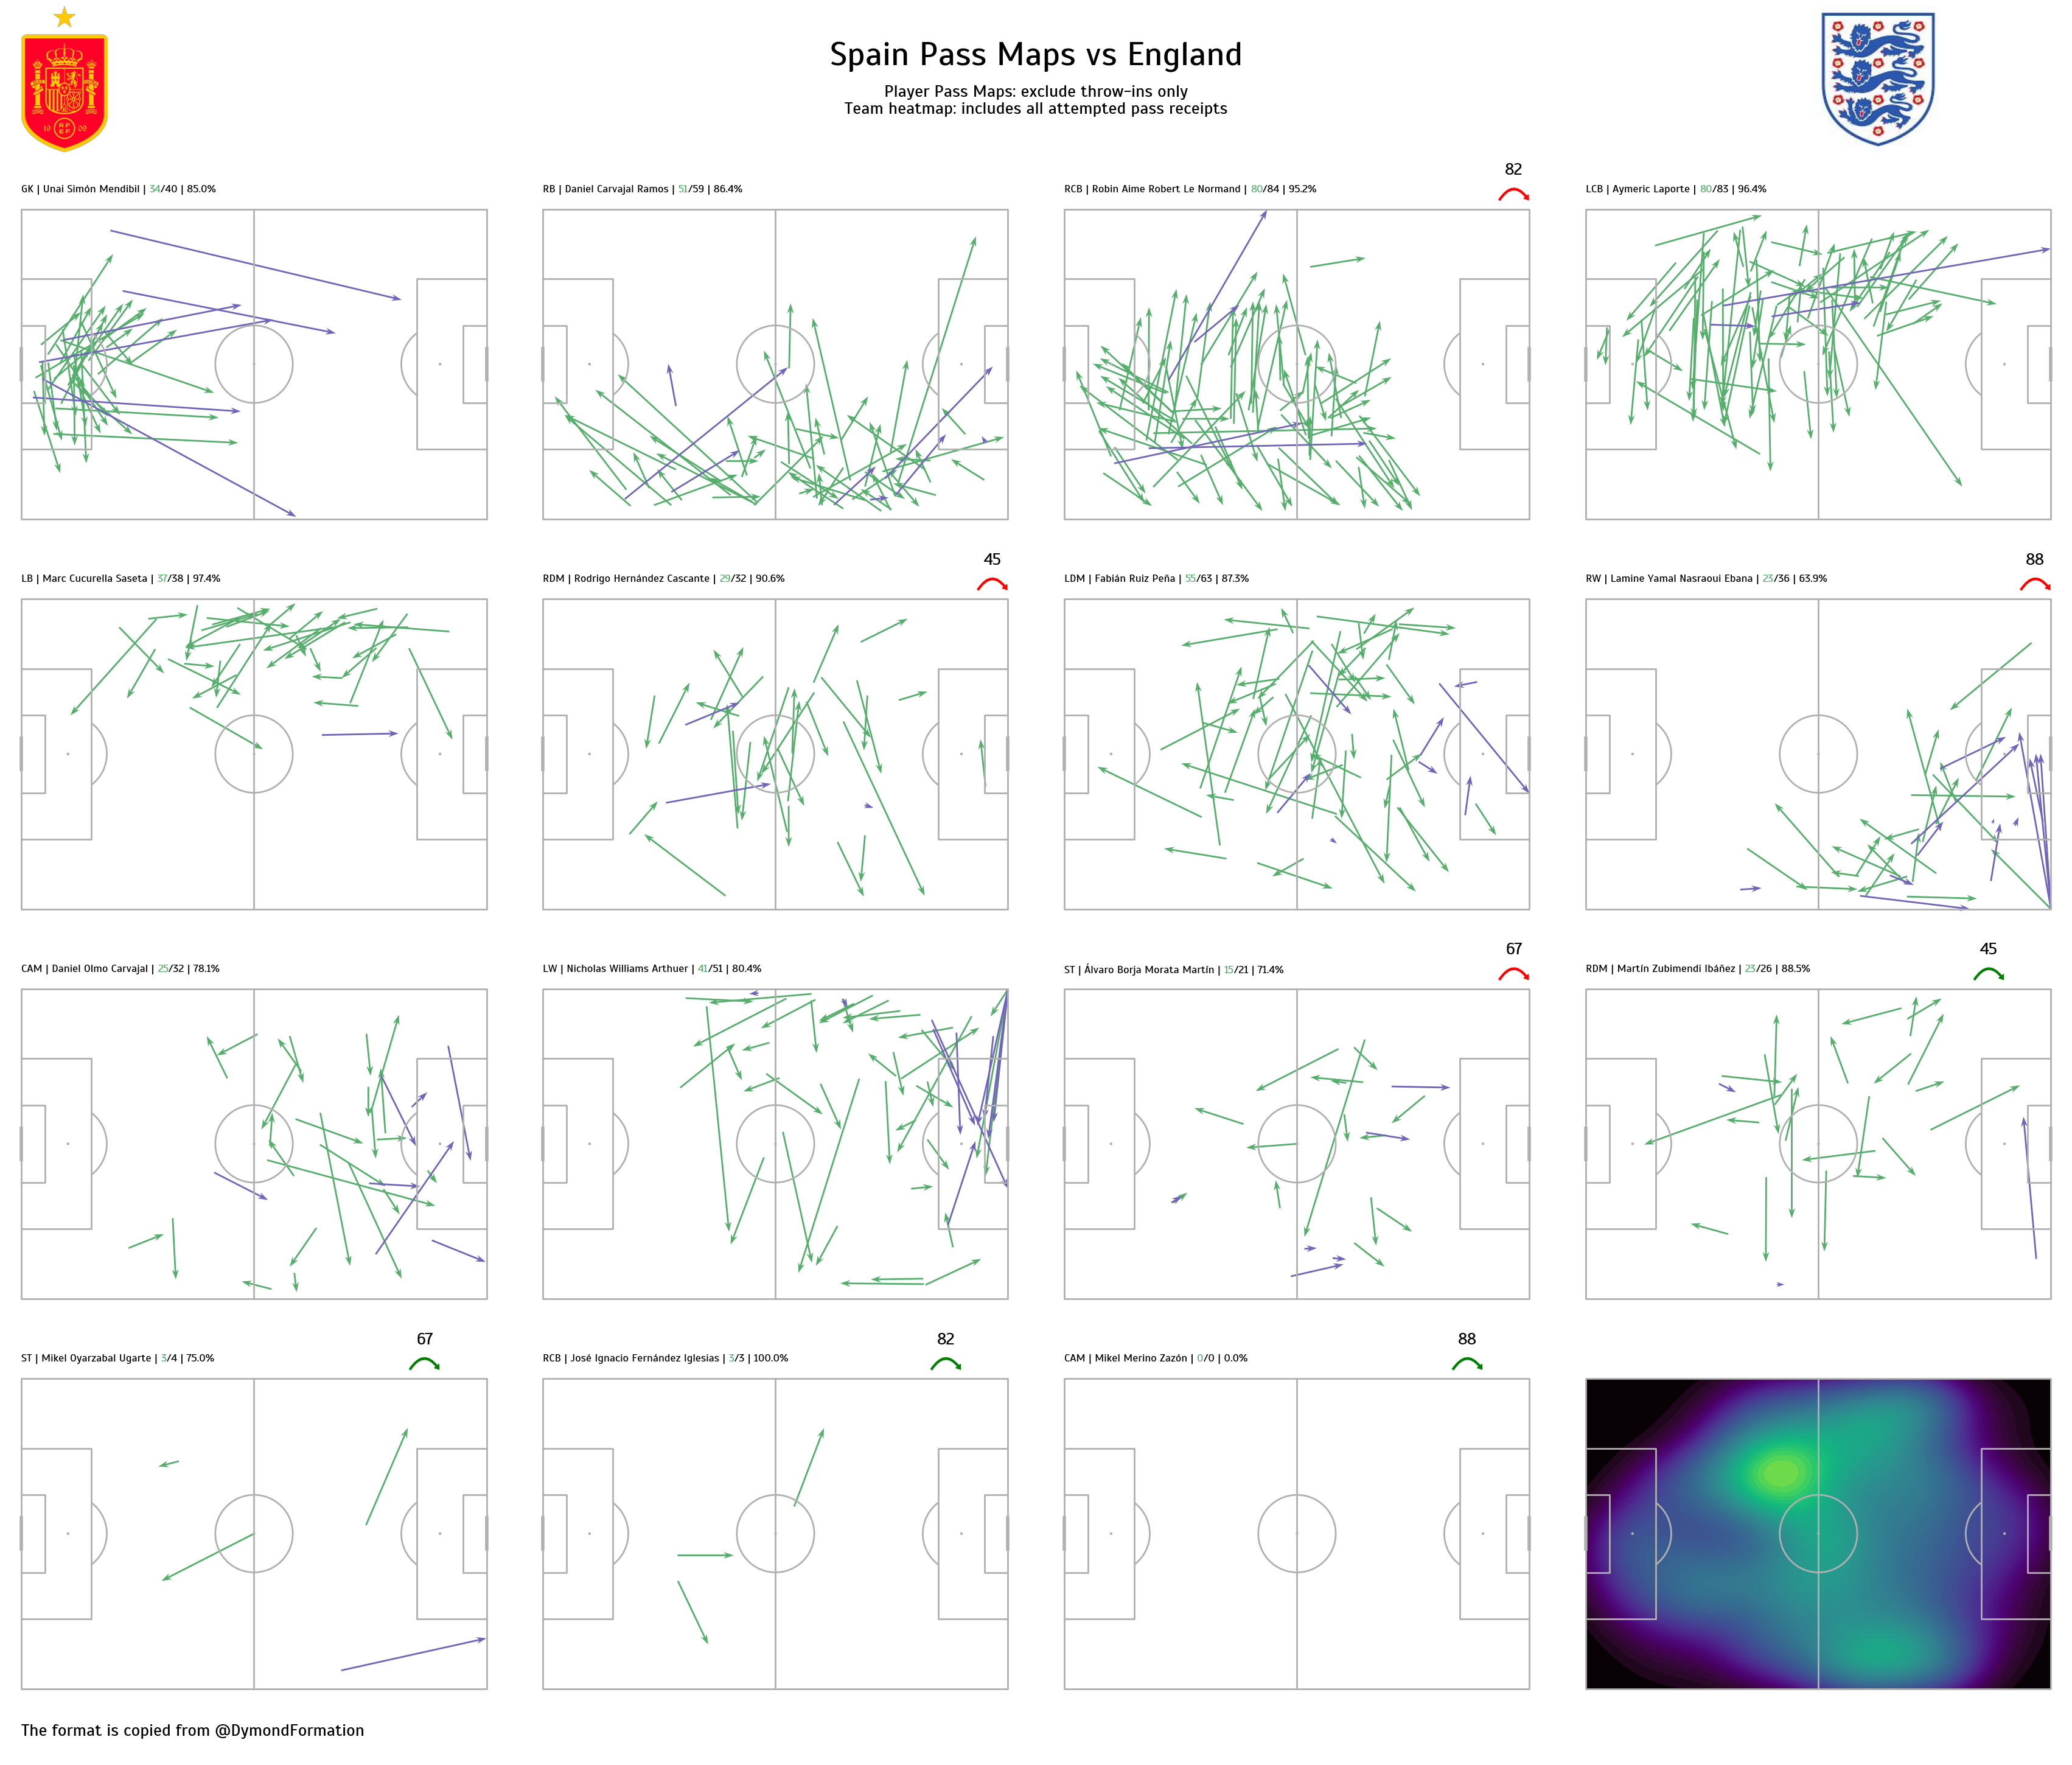

In [50]:
# filtering out some highlight_text warnings - the warnings aren't correct as the
# text fits inside the axes.
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=4, ncols=4, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)

        # plot the title for each player axis
        # here we use f-strings to combine the variables from the dataframe and text
        # we plot the title at x=0, y=-5
        # this is the left hand-side of the pitch (x=0) and between
        # top of the y-axis (y=0) and the top of the padding (y=-10, remember pad_top = 10)
        # note that the StatsBomb y-axis is inverted, so you may need
        # to change this if you use another pitch_type (e.g. 'uefa').
        # We also use the highlight-text package to highlight complete_pass green
        # so put <> around the number of completed passes.

        total_pass = len(complete_pass) + len(incomplete_pass)

        if total_pass > 0:
            completion_rate = round(100 * len(complete_pass) / total_pass, 1)
        else:
            completion_rate = 0.0  # or handle differently

        annotation_string = (f'{lineup_player.position_abbreviation} | '
                     f'{lineup_player.player_name} | '
                     f'<{len(complete_pass)}>/{total_pass} | '
                     f'{completion_rate}%')

        # total_pass = len(complete_pass) + len(incomplete_pass)
        # annotation_string = (f'{lineup_player.position_abbreviation} | '
        #                      f'{lineup_player.player_name} | '
        #                      f'<{len(complete_pass)}>/{total_pass} | '
        #                      f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    fontproperties=fm_scada.prop,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)

# plot on the last Pass Map
# (note ax=ax as we have cycled through to the last axes in the loop)
pitch.kdeplot(x=pass_receipts.x, y=pass_receipts.y, ax=ax,
              cmap=cmr.lavender,
              levels=100,
              thresh=0, fill=True)
# ax.text(0, -5, f'{team}: Pass Receipt Heatmap', ha='left', va='center',
#         fontsize=20, fontproperties=fm_scada.prop)

# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()

# endnote text
axs['endnote'].text(0, 0.5, 'The format is copied from @DymondFormation',
                    fontsize=20, fontproperties=fm_scada.prop, va='center', ha='left')
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_sb = ax_sb_logo.get_position()
# bbox_endnote = axs['endnote'].get_position()
# left = bbox_endnote.x1 - bbox_sb.width
# ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
#                        # set the bottom and height to align with the endnote
#                        bottom=axs['endnote'].get_position().y0,
#                        height=axs['endnote'].get_position().height)

# title text
axs['title'].text(0.5, 0.65, f'{team2} Pass Maps vs {team1}', fontsize=40,
                  fontproperties=fm_scada.prop, va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  fontproperties=fm_scada.prop, va='center', ha='center')
# plot logos (same height as the title_ax)
# set the barca logo to align with the left/bottom of the title axes
ax_spain_logo = add_image(spain_logo, fig,
                          left=axs['title'].get_position().x0,
                          bottom=axs['title'].get_position().y0,
                          height=axs['title'].get_position().height)
# set the deportivo logo to align with the right/bottom of the title axes
# to get the left position to align with the pitches I plotted it once with a random
# left position (e.g. 0.5) and then used the following code
# bbox_logo = ax_deportivo_logo.get_position()
# bbox_title = axs['title'].get_position()
# left = bbox_title.x1 - bbox_logo.width
ax_england_logo = add_image(england_logo, fig, left=0.8521,
                              bottom=axs['title'].get_position().y0,
                              height=axs['title'].get_position().height)
# setting this example to the gallery thumbnail
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_grid_005'

plt.show()  # If you are using a Jupyter notebook you do not need this line